In [1]:
import numpy as np

In [3]:
data = np.load('data.npz')
X = data['X']
y = data['y'].reshape(-1, 1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [5]:
print(np.unique(y, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([ 6914, 25684, 26141, 10909,  7396,  3545,  3118,  2909,  3068,
        3737, 25112, 33986,  3251,   199, 14276, 14355]))


In [6]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, Dropout

#LeNet-5 arch
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', padding='valid', input_shape = X_train.shape[1:]))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [8]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=25, shuffle=True)

Epoch 1/25
1818/1818 [==============================] - 19s 10ms/step - loss: 0.3919 - accuracy: 0.8959 - val_loss: 0.1725 - val_accuracy: 0.9516
Epoch 2/25
1818/1818 [==============================] - 18s 10ms/step - loss: 0.1451 - accuracy: 0.9592 - val_loss: 0.1240 - val_accuracy: 0.9664
Epoch 3/25
1818/1818 [==============================] - 19s 11ms/step - loss: 0.1091 - accuracy: 0.9682 - val_loss: 0.1033 - val_accuracy: 0.9705
Epoch 4/25
1818/1818 [==============================] - 19s 10ms/step - loss: 0.0903 - accuracy: 0.9730 - val_loss: 0.0887 - val_accuracy: 0.9742
Epoch 5/25
1818/1818 [==============================] - 19s 10ms/step - loss: 0.0797 - accuracy: 0.9766 - val_loss: 0.0837 - val_accuracy: 0.9744
Epoch 6/25
1818/1818 [==============================] - 19s 10ms/step - loss: 0.0709 - accuracy: 0.9786 - val_loss: 0.0717 - val_accuracy: 0.9799
Epoch 7/25
1818/1818 [==============================] - 19s 10ms/step - loss: 0.0623 - accuracy: 0.9809 - val_loss: 0.0717 -

In [9]:
model.save('models/lenet_25epochs_weighted.h5')

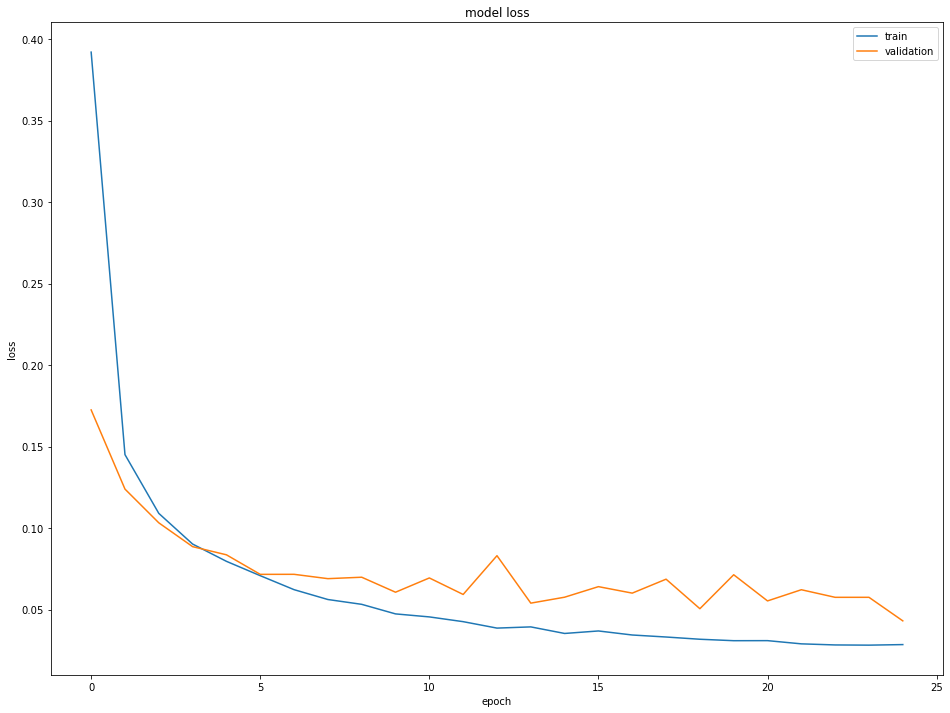

In [15]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(16, 12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

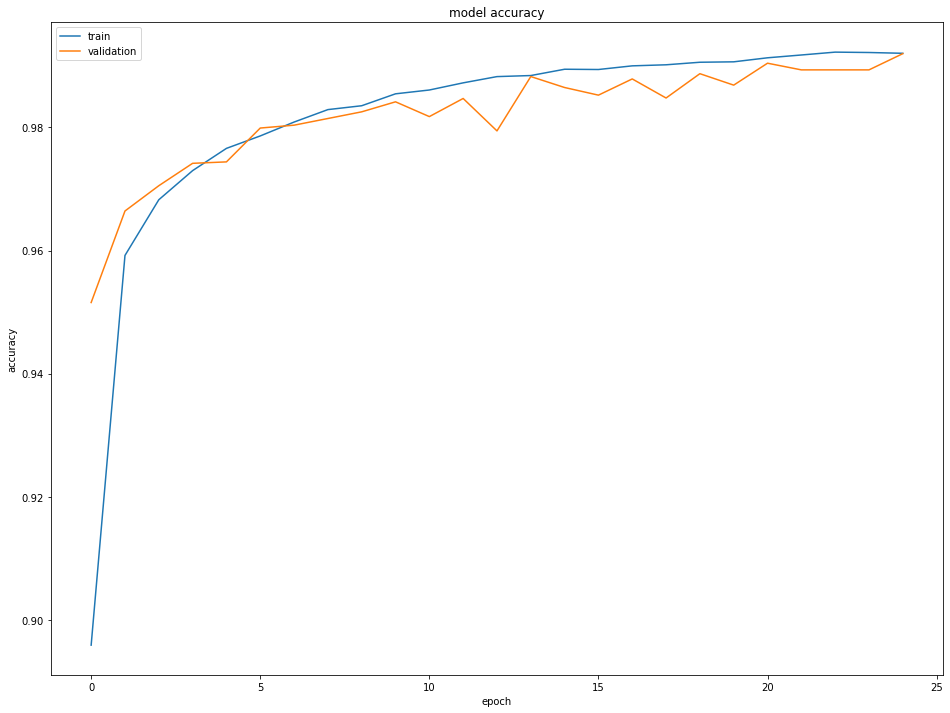

In [16]:
f, ax = plt.subplots(figsize=(16, 12))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [12]:
preds = np.argmax(model.predict(X_test), axis=1)

Accuracy: 0.989599133261105


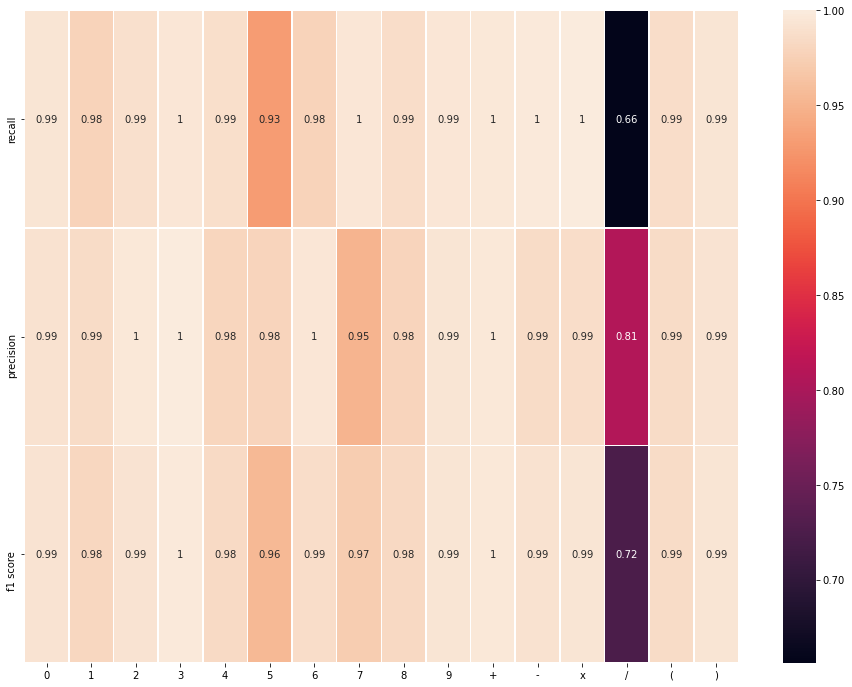

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sn
f, ax = plt.subplots(figsize=(16, 12))
print('Accuracy: {}'.format(accuracy_score(y_test, preds)))
recall = recall_score(y_test, preds, average=None)
precision = precision_score(y_test, preds, average=None)
f1 = f1_score(y_test, preds, average=None)
ax = sn.heatmap([recall, precision, f1], xticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'], yticklabels=['recall', 'precision', 'f1 score'], annot=True, linewidths=.5)

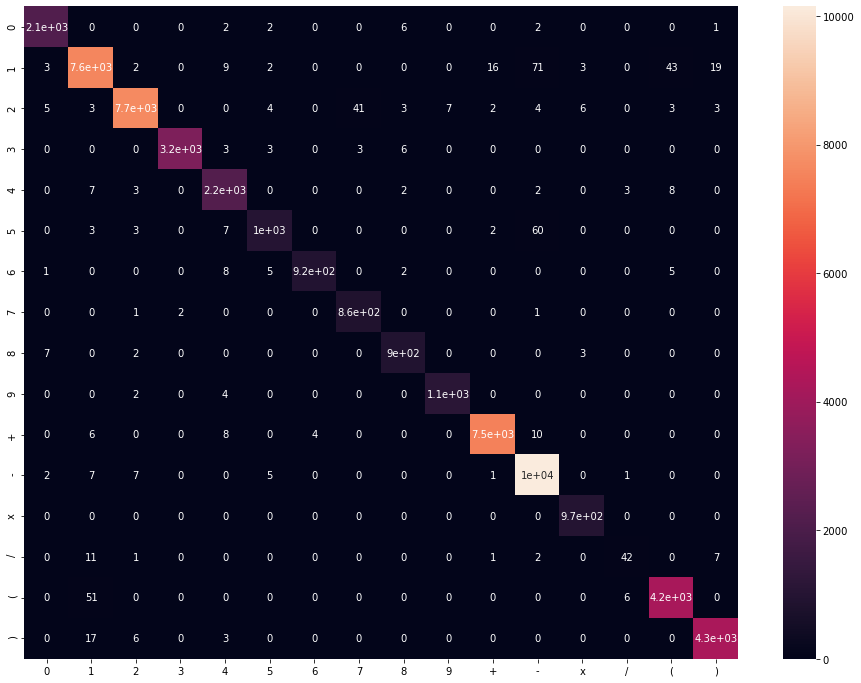

In [14]:
from sklearn.metrics import confusion_matrix
f, ax = plt.subplots(figsize=(16, 12))
cm = confusion_matrix(y_test, preds)
ax = sn.heatmap(cm, annot=True, xticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'], yticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'])